In [ ]:
import os

import numpy as np
import keras
from keras import layers
from keras import ops
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import scipy.io
import shutil

In [ ]:
print(os.environ["KERAS_BACKEND"])

tensorflow


In [ ]:
path_images = "./101_ObjectCategories/airplanes/"
path_annot = "./Annotations/Airplanes_Side_2/"
# descarga el dataset y lo extrae del zip
path_to_downloaded_file = keras.utils.get_file(
  fname="caltech_101_zipped",
  origin="https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip",
  extract=True,
  archive_format="zip",  # downloaded file format
  cache_dir="/",  # cache and extract in current directory
)
download_base_dir = os.path.dirname(path_to_downloaded_file)

# a su vez, dentro del zip extrae el .tar
shutil.unpack_archive(
  os.path.join(download_base_dir, "caltech-101", "101_ObjectCategories.tar.gz"), "."
)
shutil.unpack_archive(
  os.path.join(download_base_dir, "caltech-101", "Annotations.tar"), "."
)

# list of paths to images and annotations
image_paths = [
  f for f in os.listdir(path_images) if os.path.isfile(os.path.join(path_images, f))
]
annot_paths = [
  f for f in os.listdir(path_annot) if os.path.isfile(os.path.join(path_annot, f))
]

image_paths.sort()
annot_paths.sort()

image_size = 224  # resize input images to this size

images, targets = [], []

for i in range(0, len(annot_paths)):
  # extrae las coordenadas de las bounding boxes
  annot = scipy.io.loadmat(path_annot + annot_paths[i])["box_coord"][0]

  top_left_x, top_left_y = annot[2], annot[0]
  bottom_right_x, bottom_right_y = annot[3], annot[1]

  image = keras.utils.load_img(
      path_images + image_paths[i],
  )
  (w, h) = image.size[:2]

  # resizea las imágenes
  image = image.resize((image_size, image_size))

  # convierte img a array
  images.append(keras.utils.img_to_array(image))

  # reescala las coordenadas bounding boxes para que se ajusten al nuevo tamaño de la imagen resizeada
  targets.append(
    (
      float(top_left_x) / w,
      float(top_left_y) / h,
      float(bottom_right_x) / w,
      float(bottom_right_y) / h,
    )
  )

# dividir conj entrenamiento y conj test (convierte de lista de python a array de numpy)
(x_train), (y_train) = (
  np.asarray(images[: int(len(images) * 0.8)]),
  np.asarray(targets[: int(len(targets) * 0.8)]),
)
(x_test), (y_test) = (
  np.asarray(images[int(len(images) * 0.8) :]),
  np.asarray(targets[int(len(targets) * 0.8) :]),
)

137414764/137414764 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


In [ ]:
# construye un MLP básico con tantas capas como neuronas/capa
def mlp(x, hidden_units, dropout_rate):
  for units in hidden_units:
    x = layers.Dense(units, activation=keras.activations.gelu)(x)
    x = layers.Dropout(dropout_rate)(x)
  return x

In [ ]:
# capa custom que se encarga de partir en trozos una imagen (al igual que un transformer se fija en las palabras circundantes a una,
# aquí se fijará en los trozos o parches circundantes)
class Patches(layers.Layer):
  def __init__(self, patch_size):
    super().__init__()
    self.patch_size = patch_size

  def call(self, images):
    input_shape = ops.shape(images)
    batch_size = input_shape[0]
    height = input_shape[1]
    width = input_shape[2]
    channels = input_shape[3]
    num_patches_h = height // self.patch_size
    num_patches_w = width // self.patch_size
    patches = keras.ops.image.extract_patches(images, size=self.patch_size)
    # ahora el conjunto de imágenes tendrá forma (batch_size, patches_per_img, channels*patch_size^2)
    # eso significa que devuelvo una lista de parches, y en cada parche,
    # la información (valores) que tengo es de una región de batch_size x batch_size x canales
    patches = ops.reshape(
      patches,
      (
        batch_size,
        num_patches_h * num_patches_w,
        self.patch_size * self.patch_size * channels,
      ),
    )
    return patches

  def get_config(self):
    config = super().get_config()
    config.update({"patch_size": self.patch_size})
    return config

In [ ]:
temp_layer = Patches(10)
print(temp_layer.get_config()["patch_size"])

10


Image size: 224 X 224
Patch size: 32 X 32
49 patches per image 
3072 elements per patch


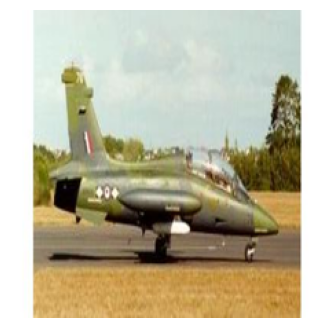

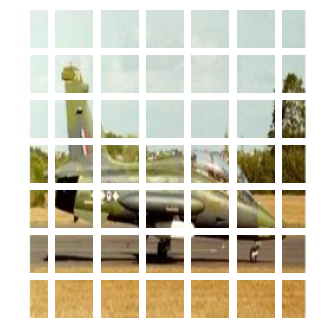

In [ ]:
patch_size = 32  # Size of the patches to be extracted from the input images

plt.figure(figsize=(4, 4))
plt.imshow(x_train[0].astype("uint8"))
plt.axis("off")

# el primer paréntesis es para construir el modelo, y el segundo es el input (API funcional)
patches = Patches(patch_size)(np.expand_dims(x_train[0], axis=0))
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"{patches.shape[1]} patches per image \n{patches.shape[-1]} elements per patch")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
  ax = plt.subplot(n, n, i + 1)
  patch_img = ops.reshape(patch, (patch_size, patch_size, 3))
  plt.imshow(ops.convert_to_numpy(patch_img).astype("uint8"))
  plt.axis("off")

In [ ]:
# esta capa se pasará al codificador del transformer. transforma un parche en un vector de dimensión "projection_dim" que lo representa
# no solo lo identifica sino que además, contiene info de su posición espacial (porque el orden es importante en las relaciones espaciales)
# cuanto más grande sea la dim de ese vector, más info se puede almacenar del parche pero el modelo overfiteará demasiado (aparte de ser más pesado etc)
# osea ahora el codificador tiene 2 matrices (projection y position_embedding) cuyos pesos aprender
class PatchEncoder(layers.Layer):
  def __init__(self, num_patches, projection_dim):
    super().__init__()
    self.num_patches = num_patches
    self.projection = layers.Dense(units=projection_dim) # codificación
    # capa para añadir info espacial, el output es del mismo tamaño que el output de "projection". una embedding layer transforma enteros en vectores
    # concretamente aquí transforma los índices de los patches en vectores
    self.position_embedding = layers.Embedding(
      input_dim=num_patches, output_dim=projection_dim
    )

  # Override function to avoid error while saving model
  def get_config(self):
    config = super().get_config().copy()
    config.update(
      {
        "input_shape": input_shape,
        "patch_size": patch_size,
        "num_patches": num_patches,
        "projection_dim": projection_dim,
        "num_heads": num_heads,
        "transformer_units": transformer_units,
        "transformer_layers": transformer_layers,
        "mlp_head_units": mlp_head_units,
      }
    )
    return config

  def call(self, patch):
    positions = ops.expand_dims(
      ops.arange(start=0, stop=self.num_patches, step=1), axis=0
    )
    projected_patches = self.projection(patch) # paso el patch a través de la capa densa para proyectarlo (codificarlo) en un vector
    encoded = projected_patches + self.position_embedding(positions) # añadir info espacial
    return encoded

In [ ]:
# esto crea el modelo entero
def create_vit_object_detector(
  input_shape,
  patch_size,
  num_patches,
  projection_dim,
  num_heads, # cada cabeza es como un filtro de las convolucionales, es decir extrae características distintas que luego se concatenan y proyecta de nuevo
  transformer_units, # después de cada "capa de atención (múltiple)" donde están las cabezas, se pasa a una densa con estas uds
  transformer_layers, # cada bloque transformer tiene una capa de atención y una capa densa
  mlp_head_units, # uds del MLP normal que hay al final
):
  inputs = keras.Input(shape=input_shape)
  # se pasan los imágenes por la capa Patches para trocear
  patches = Patches(patch_size)(inputs)
  # se pasan los parches por la capa PatchEncoder para codificarlos
  encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

  # se crean varias capas de transformer para formar el codificador. no tengo decodificador porque no estoy tratando de generar otra cosa a partir de la entrada
  # donde en cada generación sucesiva el contexto y por tanto las atenciones cambian MIENTRAS, sino que la predicción de los 4 valores es directa
  # en NLP, la salida es una secuencia con relaciones espaciales, por eso se usa un decodificador. pero aquí, las 4 coords de la box no tienen relaciones entre sí
  for _ in range(transformer_layers):
    # un bloque transformer primero tiene una capa de normalización
    x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    # luego tiene la capa de atención (múltiple y con dropout) que computará las atenciones
    # esto por detrás genera las queries/keys/values (las matrices a entrenar) <-- atención = Q * K(traspuesta) --> output = atención * V
    # cada parche tiene asociada una matriz Q que "busca qué otros parches son relevantes", y una matriz K que "informa sobre su relevancia a otros parches"
    # cuando Q y K "encajan" y la atención es alta, el output es cercano a V que es "la info de esos otros parches". estos términos son conceptuales porque al final
    # del día matrices son números y fin.
    # codificación de parches --> a partir de eso la MHA computa la Q/K/V --> se compara atención entre Q y K y se usa para modular V, que es la "info" que se feedea a la siguiente capa
    # --> blablabla se predice --> se ajustan los pesos de todas las conexiones del modelo, lo cual incluye lo que genera Q/K/V y lo que genera la codificación
    # el hecho de que sea Multi Head significa que hay varias cabezas, cada una hace (y se actualiza) sus propios Q/K/V y luego los resultados se concatenan
    # antes de pasar a la siguiente capa. Esto permite que cada uno vaya sacando info desde ángulos distintos y luego se combinen, para detectar patrones
    attention_output = layers.MultiHeadAttention(
      num_heads=num_heads, key_dim=projection_dim, dropout=0.1
    )(x1, x1) # para la matriz de auto atención (compara cada parche con el resto de parches de la img)
    # se suma la salida de la capa attention_output con los encoded_patches (es como el mecanismo residual para que no se vaya desvaneciendo la info)
    x2 = layers.Add()([attention_output, encoded_patches])
    # se vuelve a normalizar
    x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
    # MLP final del bloque transformer
    x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
    # se suma el output final del modelo con la entrada de la penúltima capa (lo mismo, residuo), y se sobreescribe en la variable encoded_patches
    encoded_patches = layers.Add()([x3, x2])

  # después de todos los bloques transformer, se normaliza, aplana y dropea
  representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
  representation = layers.Flatten()(representation)
  representation = layers.Dropout(0.3)(representation)
  # MLP final del modelo entero
  features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.3)

  bounding_box = layers.Dense(4)(
    features
  )  # el output del modelo son 4 coords de la bounding box

  return keras.Model(inputs=inputs, outputs=bounding_box)

In [ ]:
# método auxiliar para runear el exp:
def run_experiment(model, learning_rate, weight_decay, batch_size, num_epochs):
  optimizer = keras.optimizers.AdamW(
    learning_rate=learning_rate, weight_decay=weight_decay
  )

  model.compile(optimizer=optimizer, loss=keras.losses.MeanSquaredError())

  checkpoint_filepath = "vit_object_detector.weights.h5"
  checkpoint_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
  )

# a la hora de entrenar le mete un callback que hace que deje de entrenar si el val loss sube durante 10 épocas seguidas (overfit)
  history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.1,
    callbacks=[
      checkpoint_callback,
      keras.callbacks.EarlyStopping(monitor="val_loss", patience=10),
    ],
  )

  return history

In [ ]:
input_shape = (image_size, image_size, 3)  # image_size era 224
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 100
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
# tamaño (en uds) de la capa densa intermedia del MLP que hay al final de cada bloque transformer
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 4 # números de bloques transformer
mlp_head_units = [2048, 1024, 512, 64, 32]

In [ ]:
history = []
num_patches = (image_size // patch_size) ** 2

# creo el modelo como tal
vit_object_detector = create_vit_object_detector(
  input_shape,
  patch_size,
  num_patches,
  projection_dim,
  num_heads,
  transformer_units,
  transformer_layers,
  mlp_head_units,
)

# lo entreno
history = run_experiment(
  vit_object_detector, learning_rate, weight_decay, batch_size, num_epochs
)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - loss: 1.1092 - val_loss: 0.2804
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.3858 - val_loss: 0.3029
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 0.3024 - val_loss: 0.2629
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 0.2582 - val_loss: 0.2286
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - loss: 0.2096 - val_loss: 0.1958
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 0.1702 - val_loss: 0.1460
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - loss: 0.1324 - val_loss: 0.0426
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 0.0945 - val_loss: 0.0352
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - loss: 0.0693 - val_loss: 0.0149
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 0.0546 - val_loss: 0.0067
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - loss: 0.0444 - val_loss: 0.0029
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 0.0

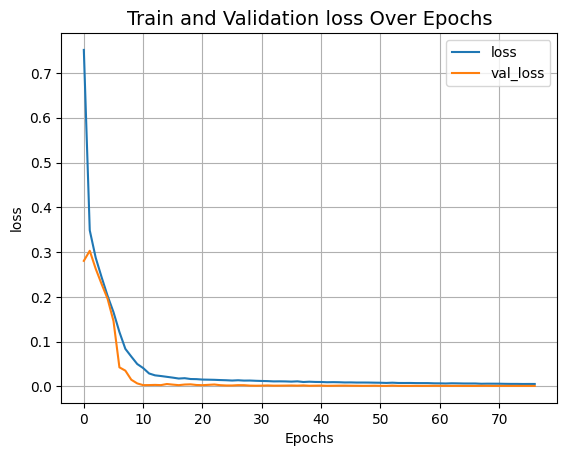

In [ ]:
# consulta el "log" del entrenamiento, busca la métrica loss y plotea:
def plot_history(item):
  plt.plot(history.history[item], label=item)
  plt.plot(history.history["val_" + item], label="val_" + item)
  plt.xlabel("Epochs")
  plt.ylabel(item)
  plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
  plt.legend()
  plt.grid()
  plt.show()

plot_history("loss")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 903ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
mean_iou: 0.8899369839910145


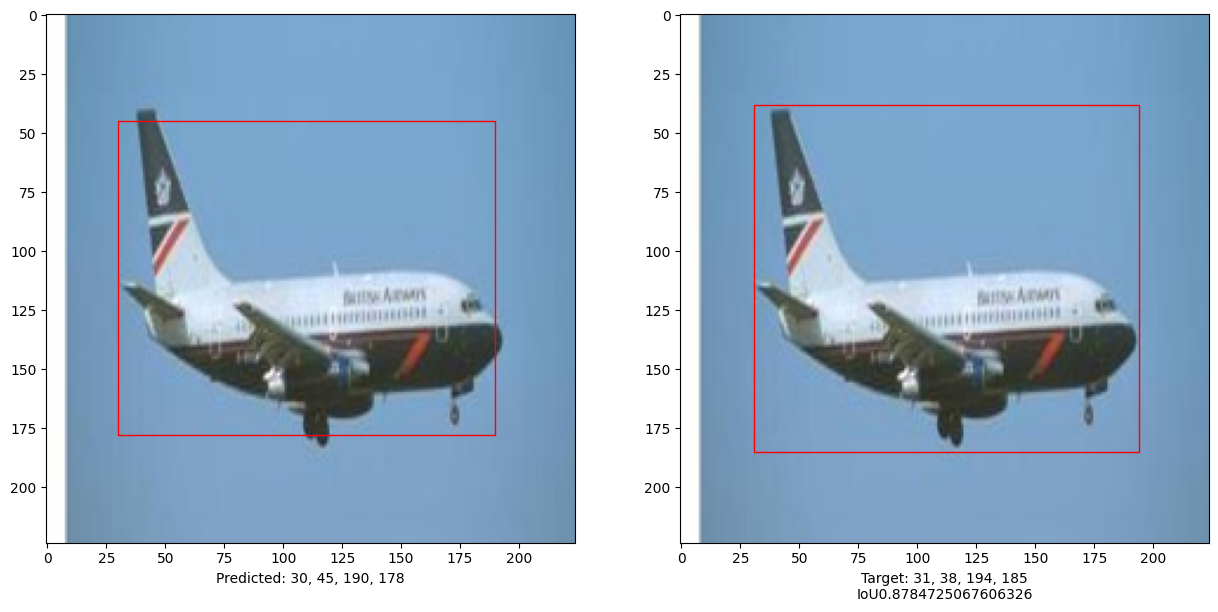

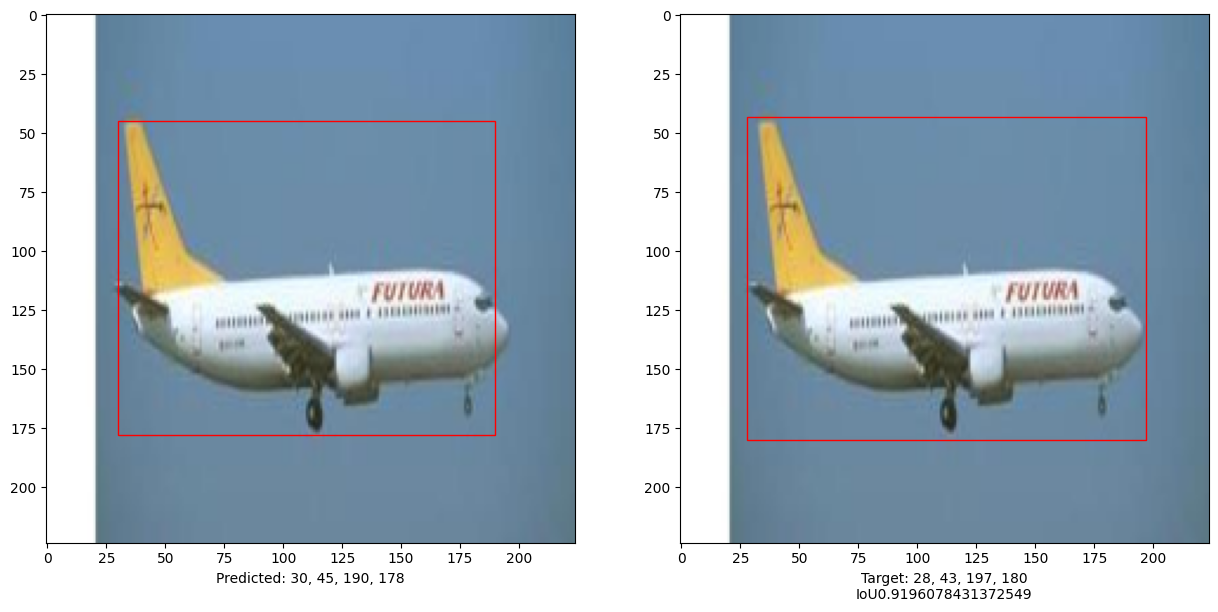

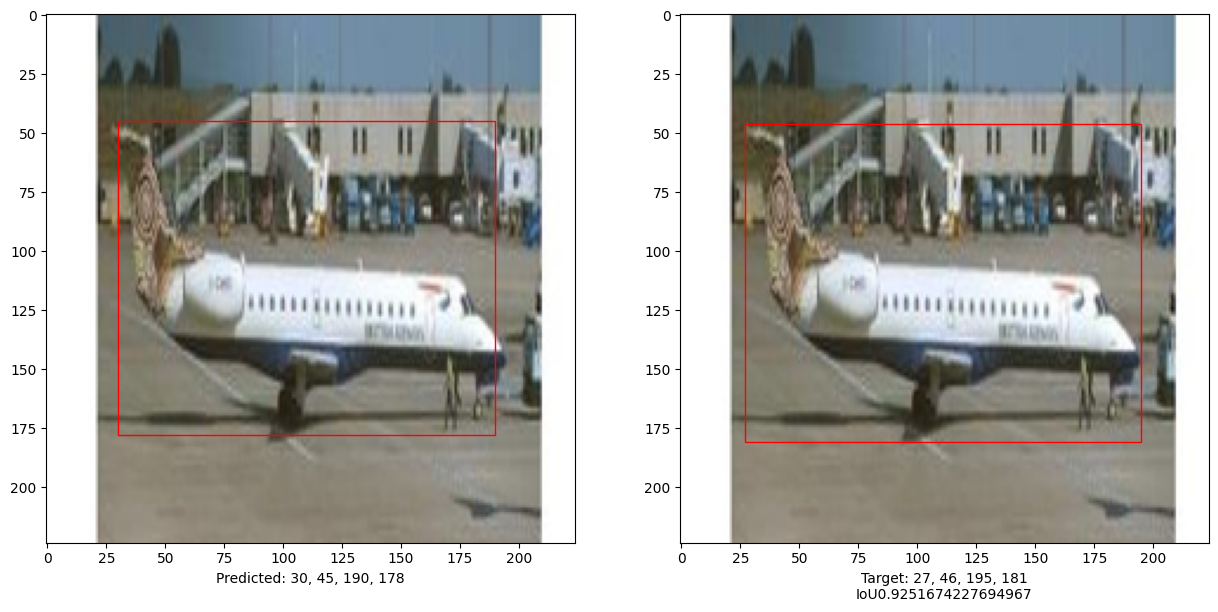

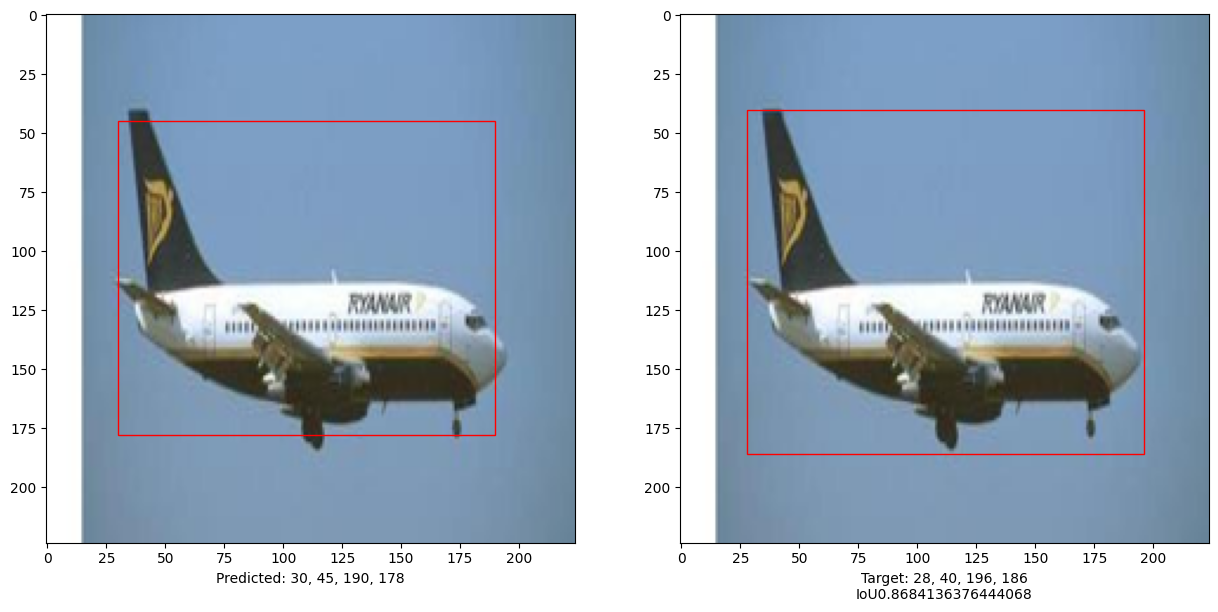

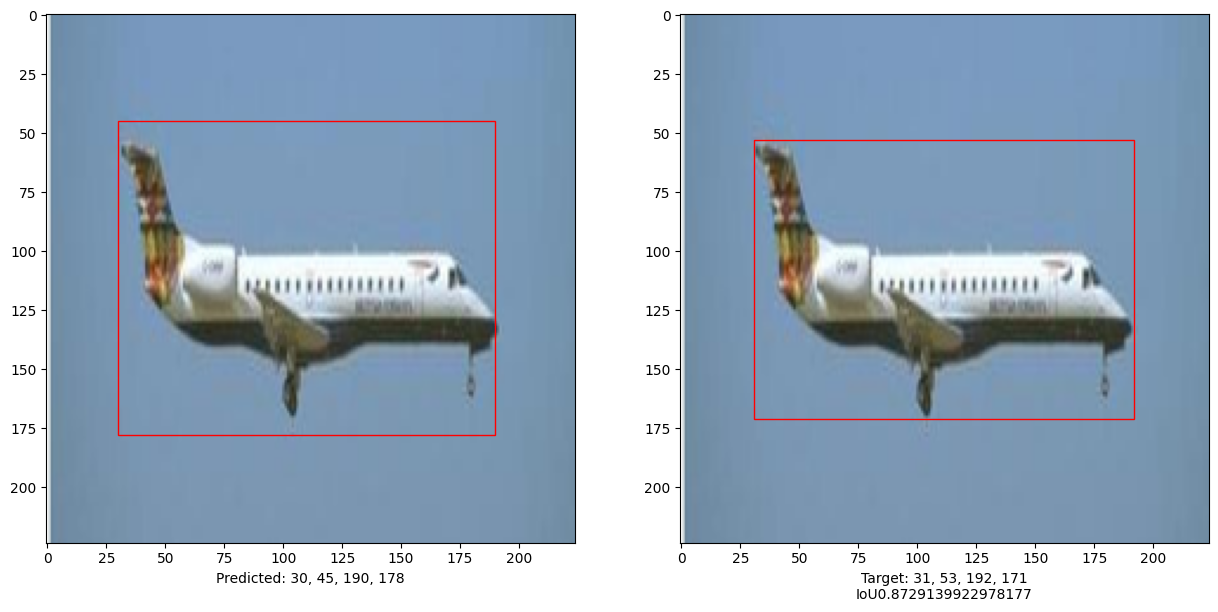

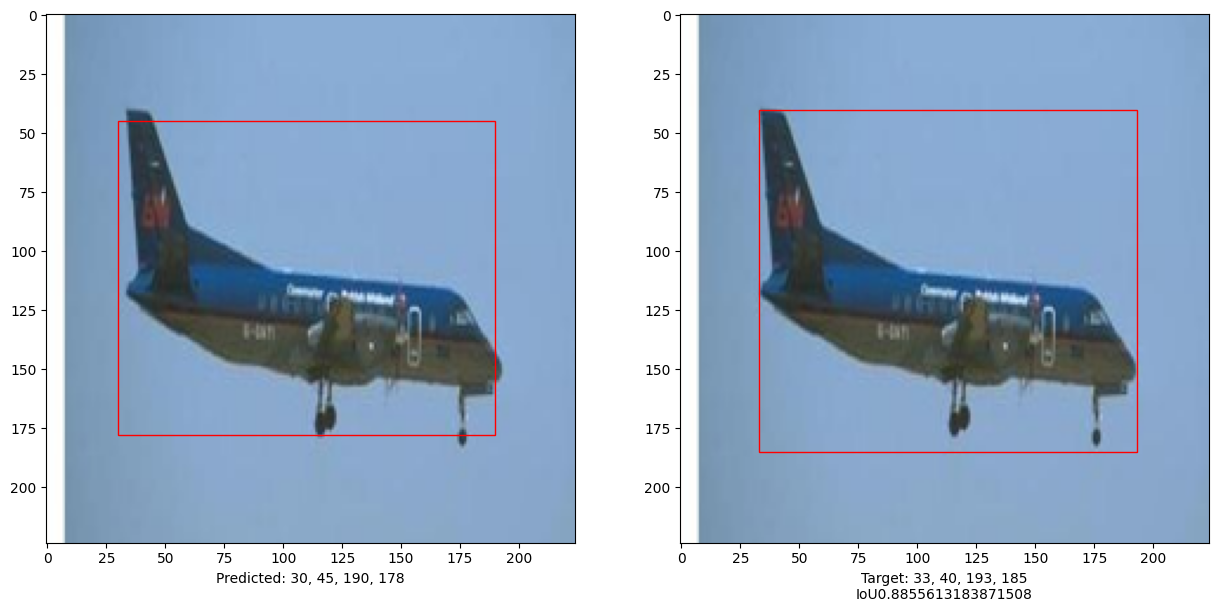

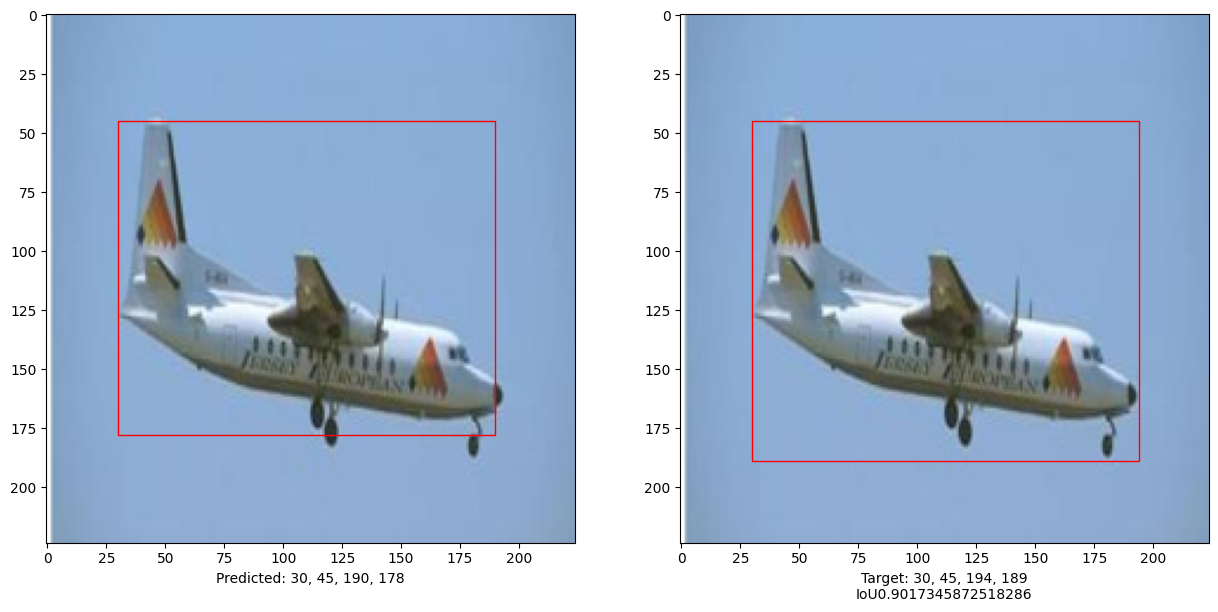

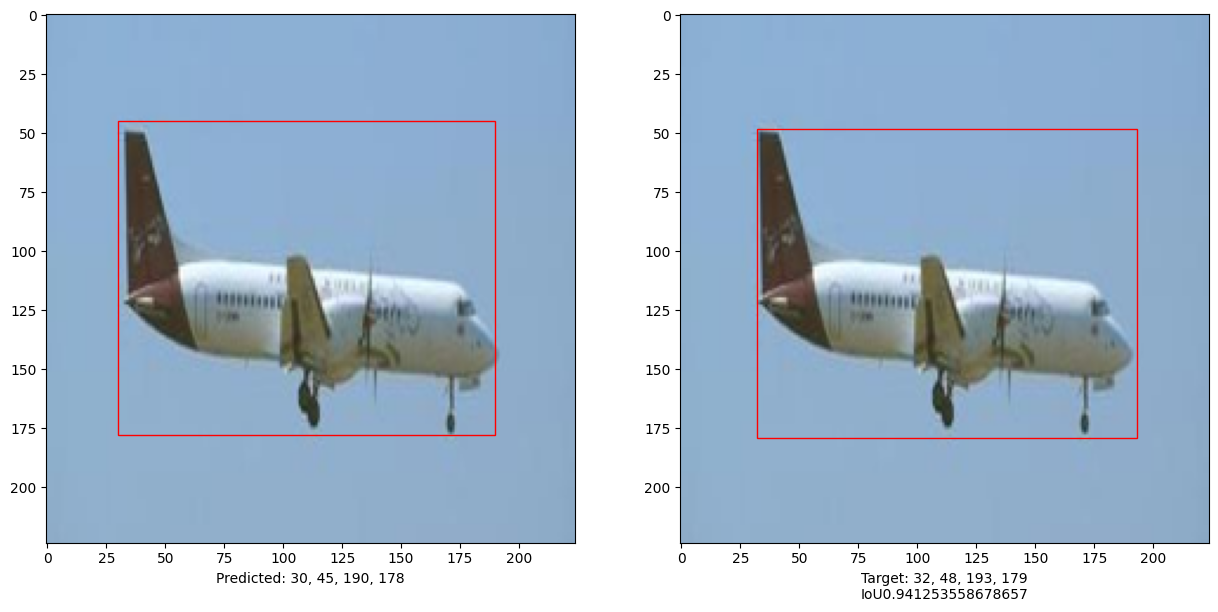

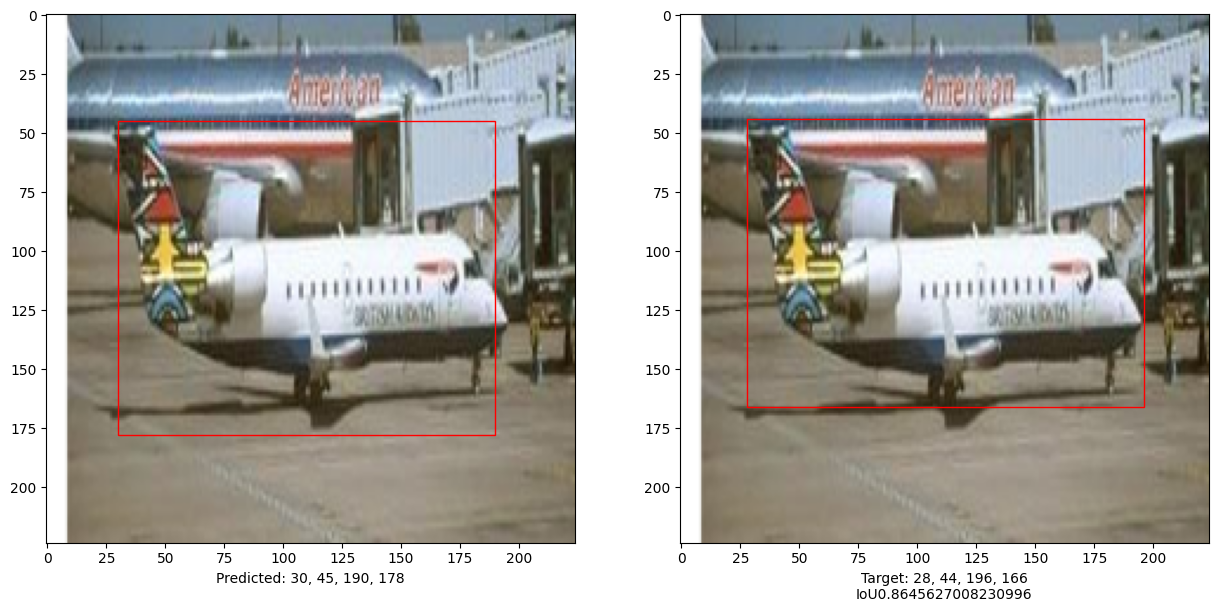

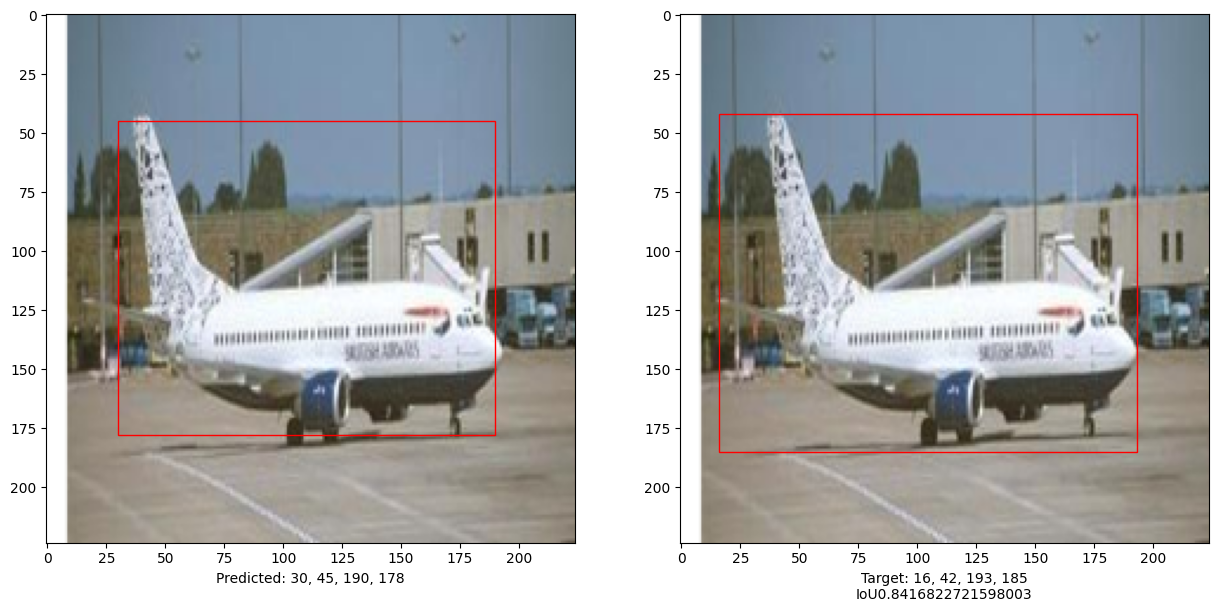

In [ ]:
import matplotlib.patches as patches

# guarda el modelo
vit_object_detector.save("vit_object_detector.keras")

# métrica IOU
def bounding_box_intersection_over_union(box_predicted, box_truth):

  top_x_intersect = max(box_predicted[0], box_truth[0])
  top_y_intersect = max(box_predicted[1], box_truth[1])
  bottom_x_intersect = min(box_predicted[2], box_truth[2])
  bottom_y_intersect = min(box_predicted[3], box_truth[3])

  intersection_area = max(0, bottom_x_intersect - top_x_intersect + 1) * max(
    0, bottom_y_intersect - top_y_intersect + 1
  )

  box_predicted_area = (box_predicted[2] - box_predicted[0] + 1) * (
    box_predicted[3] - box_predicted[1] + 1
  )
  box_truth_area = (box_truth[2] - box_truth[0] + 1) * (
    box_truth[3] - box_truth[1] + 1
  )

  return intersection_area / float(
    box_predicted_area + box_truth_area - intersection_area
  )


i, mean_iou = 0, 0

# compara los resultados de las 10 primeras imágenes
for input_image in x_test[:10]:
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
  im = input_image

  ax1.imshow(im.astype("uint8"))
  ax2.imshow(im.astype("uint8"))

  input_image = cv2.resize(
    input_image, (image_size, image_size), interpolation=cv2.INTER_AREA
  )
  input_image = np.expand_dims(input_image, axis=0)
  preds = vit_object_detector.predict(input_image)[0]

  (h, w) = (im).shape[0:2]

  top_left_x, top_left_y = int(preds[0] * w), int(preds[1] * h)

  bottom_right_x, bottom_right_y = int(preds[2] * w), int(preds[3] * h)

  box_predicted = [top_left_x, top_left_y, bottom_right_x, bottom_right_y]
  # crea la bounding box predicha
  rect = patches.Rectangle(
    (top_left_x, top_left_y),
    bottom_right_x - top_left_x,
    bottom_right_y - top_left_y,
    facecolor="none",
    edgecolor="red",
    linewidth=1,
  )
  # añade la bounding box predicha al plot
  ax1.add_patch(rect)
  ax1.set_xlabel(
    "Predicted: "
    + str(top_left_x)
    + ", "
    + str(top_left_y)
    + ", "
    + str(bottom_right_x)
    + ", "
    + str(bottom_right_y)
  )

  top_left_x, top_left_y = int(y_test[i][0] * w), int(y_test[i][1] * h)

  bottom_right_x, bottom_right_y = int(y_test[i][2] * w), int(y_test[i][3] * h)

  box_truth = top_left_x, top_left_y, bottom_right_x, bottom_right_y

  mean_iou += bounding_box_intersection_over_union(box_predicted, box_truth)

  # crea la bounding box real
  rect = patches.Rectangle(
    (top_left_x, top_left_y),
    bottom_right_x - top_left_x,
    bottom_right_y - top_left_y,
    facecolor="none",
    edgecolor="red",
    linewidth=1,
  )
  # añade la bounding box real al plot
  ax2.add_patch(rect)
  ax2.set_xlabel(
    "Target: "
    + str(top_left_x)
    + ", "
    + str(top_left_y)
    + ", "
    + str(bottom_right_x)
    + ", "
    + str(bottom_right_y)
    + "\n"
    + "IoU"
    + str(bounding_box_intersection_over_union(box_predicted, box_truth))
  )
  i = i + 1

print("mean_iou: " + str(mean_iou / len(x_test[:10])))
plt.show()